# Unsupervised Clustering Methods for Meteorological European Configurations/ Patterns


<span style="color: yellow;">- In 2.2 check if StandardScaler is good or if RobustScaler is better, for now it should be fine</span>  
<span style="color: yellow;">- optionally in standardization I can mark the cell above that has functions for memory calculation (no)</span> 

In [22]:
import xarray as xr
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans


#from statsmodels.stats.outliers_influence import variance_inflation_factor
#from sklearn.neighbors import NearestNeighbors
#from scipy.spatial.distance import pdist
#import itertools


## 1 Data Loading and Initial Analysis

The dataset used in this analysis consists of ERA5 reanalysis data downloaded from the Copernicus Climate Data Store (CDS). ERA5 is the fifth generation ECMWF atmospheric reanalysis providing comprehensive meteorological data with high spatial and temporal resolution. The dataset covers a 5-year period from January 1, 2000 to December 31, 2004, focusing on the European region. It includes four key atmospheric variables: geopotential height (z), temperature (t), and horizontal wind components (u, v), measured at three pressure levels (850 hPa, 500 hPa, and 250 hPa) on a regular 0.25° × 0.25° grid. This high-resolution gridded data provides a comprehensive representation of European atmospheric patterns and will be used to identify meteorological configurations through unsupervised clustering methods.

In [2]:
try:
    ds = xr.open_dataset('era5_ridotto.grib', engine= 'cfgrib') # XArray DataSet
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully.


In [3]:
print("Overview of the dataset:")
print(f"   • Variables: {list(ds.data_vars.keys())}")
print(f"   • Coordinates: {list(ds.coords.keys())}")

Overview of the dataset:
   • Variables: ['z']
   • Coordinates: ['number', 'time', 'step', 'isobaricInhPa', 'latitude', 'longitude', 'valid_time']


In [4]:
# Dimenision details
print("Dimension details:")
if 'latitude' in ds.dims:
    print(f"   • Latitude: {ds.dims['latitude']} points ({ds.latitude.min().values:.1f}° - {ds.latitude.max().values:.1f}°)")
if 'longitude' in ds.dims:
    print(f"   • Longitude: {ds.dims['longitude']} points ({ds.longitude.min().values:.1f}° - {ds.longitude.max().values:.1f}°)")
if 'time' in ds.dims:
    print(f"   • Time: {ds.dims['time']} steps ({pd.to_datetime(ds.time.values[0]).strftime('%Y-%m-%d')} - {pd.to_datetime(ds.time.values[-1]).strftime('%Y-%m-%d')})")
if 'isobaricInhPa' in ds.dims:
    print(f"   • Pressure levels: {ds.dims['isobaricInhPa']} levels ({list(ds.isobaricInhPa.values)} hPa)")

#Variables 
print("Variables in the dataset:")
for var in ds.data_vars:
    var_data = ds[var]
    print(f"   • {var}: {var_data.dims} - {var_data.attrs.get('long_name', 'N/A')}")
    print(f"     └─ Units: {var_data.attrs.get('units', 'N/A')}")


Dimension details:
   • Latitude: 201 points (20.0° - 70.0°)
   • Longitude: 321 points (-40.0° - 40.0°)
   • Time: 1827 steps (2000-01-01 - 2004-12-31)
   • Pressure levels: 3 levels ([np.float64(850.0), np.float64(500.0), np.float64(250.0)] hPa)
Variables in the dataset:
   • z: ('time', 'isobaricInhPa', 'latitude', 'longitude') - Geopotential
     └─ Units: m**2 s**-2


In [5]:
# Total dimensionality
total_spatial_points = 1
for dim in ['latitude', 'longitude']:
    if dim in ds.dims:
        total_spatial_points *= ds.dims[dim]

total_features = len(ds.data_vars) * ds.dims.get('isobaricInhPa', 1) * total_spatial_points
print("DIMENSIONALITY:")
print(f"   • Spatial points: {total_spatial_points}")
print(f"   • Total features per timestep: {total_features:,}")
print(f"   • Temporal samples: {ds.dims.get('time', 1)}")

DIMENSIONALITY:
   • Spatial points: 64521
   • Total features per timestep: 193,563
   • Temporal samples: 1827


### 1.1 Check quality in data

In [6]:
# Missing values check: already verified to be 0
print("MISSING VALUES: No missing values (previously verified)")

MISSING VALUES: No missing values (previously verified)


There are no missing values in the dataset

## 2 Preprocessing and Feature Selection

### 2.1 Preparing Data Matrix

#### Struttura inziale dei dati

**Scatola** = Dataset   
dentro la scatola di sono dei blocchi di fogli

**Un blocco di fogli** = un signolo giorno ( da 1 gennaio 2000 a 21 dic 2004)  -> <span style="color: red;">1827 giorni</span>  
il blocco di fogli è formato da 1 foglio 

**Un foglio contiene i valori di una variabile** =  variabile: z -> <span style="color: red;">1 variabile</span>  

Ogni foglio contiene i valori di quella variabile presi in ogni singolo punto dello 'spazio' definito dalla longitudine e dalla laitudine. Quindi in ogni foglio c'è il valore di quella variabile in ognuno dei 201(lat) × 321(lon). Una specie di tabella.  -> <span style="color: red;">64521 punti spaziali</span>

**Solo che questa tabella di valori è presa per ognuno dei 3 livelli di pressione** = 850 hPa, 500 hPa, 250 hPa -> <span style="color: red;">3 lv di pressione</span>

**TOT= 193,563 valori per blocco**   x 1827 giorni

Per la variabile z: 
__per ogni livello di pressione:  
____per ogni lat:  
______per ogni lon:  
________prendi il valore  

Se penso al foglio come una tabella con 193,563 colonne, e solo 1 riga, che rappresenta tutte le misure spaziali per quel giorno, posso mettere insieme tutti i 1827 fogli, e ottenere una matrice finale di forma (1827, 193,563). Ogni riga è un giorno. Ogni colonna è una variabile a una certa posizione e pressione.


#### Struttura finale dei dati

L’obiettivo è trasformare tutto in una tabella 2D:

           feature_1  feature_2  ...  feature_193,563 
time_1 →      ...        ...             ...  
time_2 →      ...        ...             ...  
  ⋮                             
time_1827 →   ...        ...             ...  

Righe: 1827 (una per ogni timestep)  
Colonne: 193,563 (una per ogni combinazione di punto spaziale × variabile)  

Organizzazione delle Colonne:  -> no  
[z_850_lat0_lon0, z_850_lat0_lon1, ..., z_500_lat0_lon0, ..., z_250_lat0_lon0, ...,  
 t_850_lat0_lon0, t_850_lat0_lon1, ..., t_500_lat0_lon0, ..., t_250_lat0_lon0, ...,  
 u_850_lat0_lon0, u_850_lat0_lon1, ..., u_500_lat0_lon0, ..., u_250_lat0_lon0, ...,  
 v_850_lat0_lon0, v_850_lat0_lon1, ..., v_500_lat0_lon0, ..., v_250_lat0_lon0, ...]  

In [7]:
# Convert dataset to 2D array 
def prepare_data_matrix(dataset):
    """Converts xarray dataset to 2D matrix"""
    data_matrices = {}
    
    for var in dataset.data_vars:
        print(f"   • Processing {var}...")
        var_data = dataset[var]
        
        # Reorganize dimensions: (time, features)
        if 'time' in var_data.dims:
            # Stack all non-temporal dimensions
            spatial_dims = [dim for dim in var_data.dims if dim != 'time']
            if spatial_dims:
                stacked = var_data.stack(features=spatial_dims)      # From: var[time=1827, pressure=3, lat=201, lon=321]
                matrix = stacked.values  # shape: (time, features)   # To:  var[time=1827, features=193563]  (3×201×321=193563)
            else:
                matrix = var_data.values.reshape(-1, 1)  # For variables without spatial dimensions
        else:
            matrix = var_data.values.flatten().reshape(1, -1)
        
        data_matrices[var] = matrix
    
    # Concatenate all variables
    all_matrices = list(data_matrices.values())
    combined_matrix = np.concatenate(all_matrices, axis=1) # concatenate along the columns (horizontally)

    return combined_matrix, data_matrices


In [8]:
print("PREPARING DATA MATRIX")
X, data_matrices = prepare_data_matrix(ds)
print(f"Data Matrix: {X.shape} (samples, features)")

PREPARING DATA MATRIX
   • Processing z...


Data Matrix: (1827, 193563) (samples, features)


Prima (per la variabile z):  
z[time=0, pressure=850, lat=37.5, lon=12.0] = 1234.5  
z[time=0, pressure=500, lat=37.5, lon=12.0] = 5678.9  
z[time=0, pressure=250, lat=37.5, lon=12.0] = 9876.1  
...  

Dopo lo stack:  
z[time=0, feature_0] = 1234.5  # (850hPa, lat37.5, lon12.0)  
z[time=0, feature_1] = 5678.9  # (500hPa, lat37.5, lon12.0)    
z[time=0, feature_2] = 9876.1  # (250hPa, lat37.5, lon12.0)  
...  

Concatenazione finale:

X[time=0] = [z_features (tti i valori di z)... | t_features... | u_features... | v_features...]


### 2.2 Standardization

The next step is to standardize the data for each feature to achieve zero mean and unit variance (standard deviation = 1).Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data   
We use Scikit-learn's StandardScaler, which computes the mean and standard deviation across all samples. However, due to the massive dimensionality of our dataset (1827 × 774,252), loading all data into memory simultaneously would cause RAM saturation. To solve thi memory constraint we employ the _.partial_fit()_ method, which enables incremental standardization by processing the data in a streaming fashion - one sample at a time. This approach allows us to handle large datasets that exceed available memory while maintaining the same statistical properties as batch processing.

Media e varianza si possono calcolare incrementalmente invece che su tutti i dati in blocco.
Equivalente matematico:  
Invece di: mean = sum(all_data) / n  
Posso usare: mean_new = (mean_old * (n-1) + x_new) / n  

Per ora uso StandardScaler poichè i valori sono ben distribuiti. Ma nel caso la PCA o il Kmeans venissero strani posso provare ad utilizzare RobustScaler che è più robusto agli outliers.
  

Se ho problemi di RAM, posso:

    Ridurre le feature prima della standardizzazione (es. PCA incrementale).

In [9]:
print("STANDARDIZATION - Memory-Safe")

sample_check = X[:3, :10].mean(axis=0)

batch_size = 1
print(f"   • Batch size: {batch_size} ")

scaler = StandardScaler()

# Only proceed if data is not already standardized
if not np.allclose(sample_check, 0, atol=0.1):
    # Step 1: Calculate statistics one sample at a time
    print("   • Phase 1: Calculate statistics (1 sample at a time)...")
    for i in range(0, X.shape[0], batch_size):
        scaler.partial_fit(X[i:i+1])   # Online computation of mean and std on X for later scaling

        # Log every 500 samples to reduce overhead
        if i % 500 == 0:
            progress = (i / X.shape[0]) * 100
            gc.collect()

    print("   • partial_fit completed")

    # Step 2: Direct in-place transformation 
    print("   • Phase 2: In-place transformation")
    for i in range(0, X.shape[0]):
        # Direct transformation on single row 
        X[i:i+1] = scaler.transform(X[i:i+1])   # Perform standardization by centering and scaling

        # Log every 500 samples to reduce overhead
        if i % 500 == 0:
            progress = (i / X.shape[0]) * 100

            # Garbage collection every 1000 samples
            if i % 1000 == 0:
                gc.collect()

    print(f"   • Standardization completed")

print(f"   • Dataset shape: {X.shape}")

print("   • Standardization verification (per feature):")

# Check mean and std for first 3 features
mean_per_feature = X[:, :3].mean(axis=0)
std_per_feature = X[:, :3].std(axis=0)

print(f"   • Mean (per feature, first 3 feature): {mean_per_feature}")
print(f"   • Std  (per feature, first 3 feature): {std_per_feature}")

# Check mean and std for first 10 features
print("   • Mean (per feature, first 10 feature):", X[:, :10].mean(axis=0))
print("   • Std  (per feature, first 10 feature):", X[:, :10].std(axis=0))

STANDARDIZATION - Memory-Safe
   • Batch size: 1 
   • Phase 1: Calculate statistics (1 sample at a time)...
   • partial_fit completed
   • Phase 2: In-place transformation
   • partial_fit completed
   • Phase 2: In-place transformation
   • Standardization completed
   • Dataset shape: (1827, 193563)
   • Standardization verification (per feature):
   • Mean (per feature, first 3 feature): [-2.9361894e-08  2.4402997e-08 -5.4808869e-09]
   • Std  (per feature, first 3 feature): [0.9999999  1.0000001  0.99999994]
   • Mean (per feature, first 10 feature): [-2.9361894e-08  2.4402997e-08 -5.4808869e-09 -2.0227082e-08
  6.0942241e-08  1.1744757e-09 -1.3049731e-08  2.7404434e-08
  2.1010067e-08 -3.6147753e-08]
   • Std  (per feature, first 10 feature): [0.9999999  1.0000001  0.99999994 1.0000004  0.99999994 0.9999995
 1.0000007  1.0000004  0.99999964 1.0000002 ]
   • Standardization completed
   • Dataset shape: (1827, 193563)
   • Standardization verification (per feature):
   • Mean (pe

PRIMA della standardizzazione:  
Colonna 0 (z_850_lat0_lon0): Valori di geopotenziale a 850hPa nel punto (lat0,lon0) per TUTTI i 1827 giorni  
Esempio: [10815, 10820, 10805, 10830, ...] → 1827 valori diversi  

DOPO la standardizzazione:  
Colonna 0: Calcolo mean e std di quei 1827 valori  
Esempio: mean=10818, std=15  
Ogni valore diventa: (valore_originale - 10818) / 15  
Risultato: [-0.2, 0.13, -0.87, 0.8, ...] → media=0, std=1  

Cosa Significa:
La standardizzazione normalizza ogni punto geografico-variabile rispetto alla sua variabilità temporale.

Ad esempio:   
Prima: Geopotenziale a Milano a 850hPa varia da 1480 a 1520 metri nei 5 anni  
Dopo: Questi valori diventano da -2.1 a +1.8 (media=0, std=1)  
Interpretazione: Ora puoi confrontare la "anomalia" di Milano con quella di Roma, anche se hanno scale diverse!  

Now, an esample of standardization for 3 points is shown.

![Esempio Standardizzazione](./standardization_example.png)

### 2.3 Principal Component Analysis

Step 1: PCA Incrementale  
L'obiettivo è di riuscire a descrivere un dato sistema in modo chiaro e sufficientemente accurato
usando un numero ridotto di variabili, mantenendo il più possibile l’informazione (varianza) contenuta nei dati originali.  

IncrementalPCA elabora i dati un batch alla volta (100 righe) e aggiorna i componenti principali progressivamente.

<span style="color: orange;">Non adatta se:  
le variabili originali hanno un significato interpretativo importante (perché le componenti PCA sono combinazioni lineari difficili da interpretare)</span>



**Varianza = quanto i dati si "spargono" attorno alla media**
- La PCA cerca le **direzioni di MASSIMA varianza**   
- Trova i pattern meteorologici che cambiano di più nel tempo  
- Cattura le configurazioni atmosferiche principali (NAO, anticicloni, ecc.)  

<span style="color: orange;"> La PCA non assegna etichette o categorie: ogni campione rimane un punto nello spazio, solo rappresentato in modo più efficiente. Le componenti non sono cluster, ma assi cartesiani scelti in modo che la varianza sia massima lungo il primo asse, poi il secondo ecc. Quindi la PCA non è un clustering, anche se può rivelare struttura nei dati.

In [10]:
print("INCREMENTAL PCA ANALYSIS")

n_components = 30   # Reduced to 60 components for safety with batch processing
batch_size = 100    # Increased batch size to accommodate more components

print(f"   • Target components: {n_components}")
print(f"   • Batch size: {batch_size}")
print(f"   • Data shape: {X.shape}")

# Ensure batch_size doesn't exceed total samples
if batch_size > X.shape[0]:
    batch_size = X.shape[0]
    print(f"   • Adjusted batch size to total samples: {batch_size}")

# Initialize IncrementalPCA
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

print("   • Phase 1: Fitting incremental PCA...")
# Fit the PCA incrementally
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    ipca.partial_fit(batch)
    
    # Progress tracking
    if i % (batch_size * 10) == 0:  # Every 10 batches
        progress = min(100, (i + batch_size) / X.shape[0] * 100)
        print(f"      └─ Progress: {progress:.1f}%")
        gc.collect()

print("   • Phase 2: Transforming data...")
# Transform data in batches to avoid memory issues
X_pca = np.zeros((X.shape[0], n_components))

for i in range(0, X.shape[0], batch_size):
    end_idx = min(i + batch_size, X.shape[0])
    batch = X[i:end_idx]
    X_pca[i:end_idx] = ipca.transform(batch)
    
    # Progress tracking
    if i % (batch_size * 10) == 0:  # Every 10 batches
        progress = min(100, (i + batch_size) / X.shape[0] * 100)
        print(f"      └─ Progress: {progress:.1f}%")
        gc.collect()

print(f"   • PCA transformation completed!")
print(f"   • Original shape: {X.shape}")
print(f"   • PCA shape: {X_pca.shape}")

# Analyze explained variance
explained_variance_ratio = ipca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("\n   • VARIANCE ANALYSIS:")
print(f"   • Total explained variance ({n_components} components): {cumulative_variance[-1]:.3f}")

# Find components needed for different variance thresholds
thresholds = [0.80, 0.85, 0.90, 0.95]
for threshold in thresholds:
    n_comp_needed = np.argmax(cumulative_variance >= threshold) + 1
    if cumulative_variance[-1] >= threshold:
        print(f"   • {threshold*100}% variance: {n_comp_needed} components")
    else:
        print(f"   • {threshold*100}% variance: >{n_components} components needed")

# Show variance distribution for first components
print(f"\n   • First 10 components variance: {explained_variance_ratio[:10]}")
print(f"   • First 30 components cumulative: {cumulative_variance[29]:.3f}")

INCREMENTAL PCA ANALYSIS
   • Target components: 30
   • Batch size: 100
   • Data shape: (1827, 193563)
   • Phase 1: Fitting incremental PCA...
      └─ Progress: 5.5%
      └─ Progress: 5.5%


      └─ Progress: 60.2%
   • Phase 2: Transforming data...
   • Phase 2: Transforming data...
      └─ Progress: 5.5%
      └─ Progress: 5.5%
      └─ Progress: 60.2%
      └─ Progress: 60.2%
   • PCA transformation completed!
   • Original shape: (1827, 193563)
   • PCA shape: (1827, 30)

   • VARIANCE ANALYSIS:
   • Total explained variance (30 components): 0.958
   • 80.0% variance: 8 components
   • 85.0% variance: 10 components
   • 90.0% variance: 15 components
   • 95.0% variance: 26 components

   • First 10 components variance: [0.42217001 0.10209688 0.07776937 0.07026954 0.05597371 0.04238547
 0.02796267 0.02185681 0.01936856 0.01796209]
   • First 30 components cumulative: 0.958
   • PCA transformation completed!
   • Original shape: (1827, 193563)
   • PCA shape: (1827, 30)

   • VARIANCE ANALYSIS:
   • Total explained variance (30 components): 0.958
   • 80.0% variance: 8 components
   • 85.0% variance: 10 components
   • 90.0% variance: 15 components
   • 95.0% variance:

La PCA con 60 componenti spiega l’98.3% della varianza totale.  

Il grafico mostra chiaramente un forte “elbow” nei primi componenti: la prima componente da sola spiega il 26.2% (!), la seconda il 7.1%, e poi via via la varianza scende rapidamente → significa che gran parte dell’informazione è concentrata nei primi component

    Analisi della varianza

    calcola la percentuale di varianza spiegata da ciascun componente  
    calcola la cumulata (cioè quanto “copre” l’informazione aggiungendo via via più componenti)  
    stampa quante componenti servono per spiegare almeno l’80%, 90%, 95% della varianza



- la prima componente da sola spiega il 42% della varianza → fortemente dominante
- le prime 10 componenti arrivano circa al 85% cumulato


VARIANCE VISUALIZATION


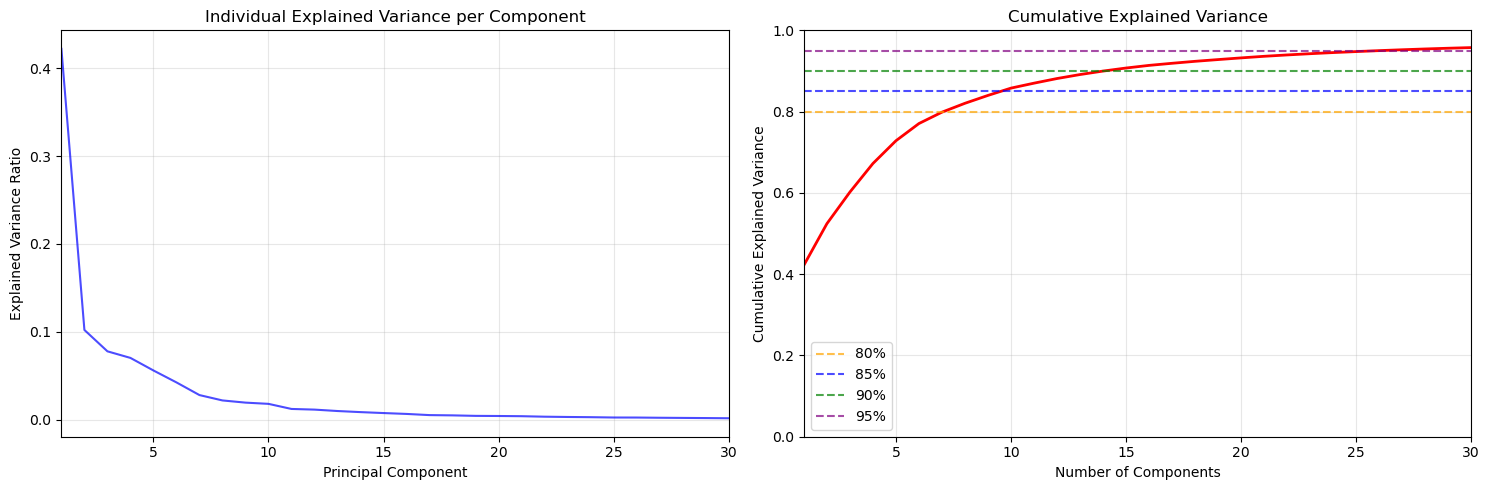

In [11]:
# Visualization of explained variance
print("VARIANCE VISUALIZATION")

# Create plots for variance analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Individual explained variance ratio
ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'b-', alpha=0.7)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Individual Explained Variance per Component')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, n_components) 

# Plot 2: Cumulative explained variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-', linewidth=2)
ax2.axhline(y=0.80, color='orange', linestyle='--', alpha=0.7, label='80%')
ax2.axhline(y=0.85, color='blue', linestyle='--', alpha=0.7, label='85%')
ax2.axhline(y=0.90, color='green', linestyle='--', alpha=0.7, label='90%')
ax2.axhline(y=0.95, color='purple', linestyle='--', alpha=0.7, label='95%')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, n_components)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()


Grafico a sinistra: varianza spiegata individualmente da ciascuna componente (curve blu decrescente).

Grafico a destra: varianza cumulativa spiegata dalle componenti, con linee orizzontali alle soglie 80%, 90%, 95% per capire visivamente quanti componenti servono.

    grafico a sinistra: varianza spiegata per singola componente
    (di solito decresce velocemente, “elbow” shape)  
    mostra la varianza spiegata da ciascun componente  
    conferma che la prima componente è molto informativa  
    curva a gomito → tipico nei dati ridondanti

    grafico a destra: varianza spiegata cumulata
    (sale a gradini, fino a saturare verso 1)  
    mostra la varianza cumulata
    le linee orizzontali (80%, 90%, 95%) ti fanno capire quanto margine hai  
    la curva rossa sale rapidamente ma si stabilizza, quindi i componenti successivi hanno impatto minore

<span style="color: orange;">la PCA permette di proiettare i dati in un nuovo spazio ridotto che mantiene la maggior parte dell’informazione
Inoltre, facilita interpretazioni fisiche (ad esempio i primi componenti possono corrispondere a pattern meteorologici dominanti) e riduce il rumore e la ridondanza tra variabili</span>

In [12]:
n_components_final = 30  # Final number of components based on variance analysis
print(f"   • Original data shape: {X.shape}")
print(f"   • PCA full shape: {X_pca.shape}")

variance_explained = cumulative_variance[n_components_final-1]
print(f"   • Actual variance explained: {variance_explained:.3f} ({variance_explained*100:.1f}%)")


   • Original data shape: (1827, 193563)
   • PCA full shape: (1827, 30)
   • Actual variance explained: 0.958 (95.8%)


#### 2.3.1 Visualization of the first components

I plots 2D/3D servono per:

- PC1 vs PC2: scatter plot per vedere se ci sono cluster naturali
- PC1 vs PC2 vs PC3: scatter 3D per pattern più complessi
- Istogrammi delle prime 4-5 componenti  
Se vedo "nuvole" separate → suggerisce struttura a cluster

VISUALIZATION OF PRINCIPAL COMPONENTS


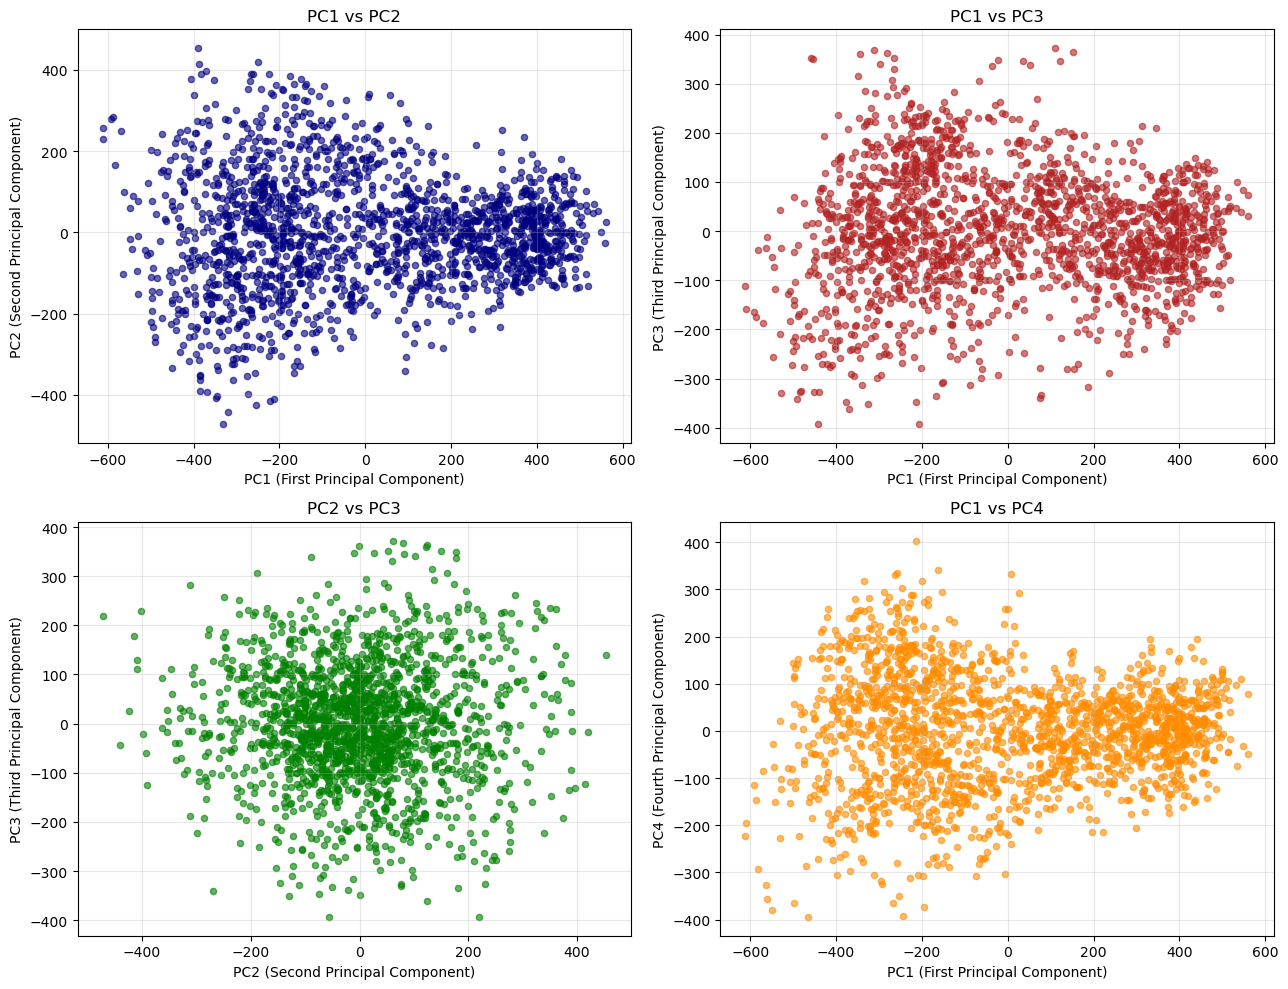

In [13]:
print("VISUALIZATION OF PRINCIPAL COMPONENTS")

# 1. SCATTER PLOT 2D: PC1 vs PC2
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 10))

ax1.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=20, c='navy')
ax1.set_xlabel('PC1 (First Principal Component)')
ax1.set_ylabel('PC2 (Second Principal Component)')
ax1.set_title('PC1 vs PC2')
ax1.grid(True, alpha=0.3)

# PC1 vs PC3 scatter
ax2.scatter(X_pca[:, 0], X_pca[:, 2], alpha=0.6, s=20, c='firebrick')
ax2.set_xlabel('PC1 (First Principal Component)')
ax2.set_ylabel('PC3 (Third Principal Component)')
ax2.set_title('PC1 vs PC3')
ax2.grid(True, alpha=0.3)

# PC2 vs PC3 scatter
ax3.scatter(X_pca[:, 1], X_pca[:, 2], alpha=0.6, s=20, c='green')
ax3.set_xlabel('PC2 (Second Principal Component)')
ax3.set_ylabel('PC3 (Third Principal Component)')
ax3.set_title('PC2 vs PC3')
ax3.grid(True, alpha=0.3)

# PC1 vs PC4 scatter
ax4.scatter(X_pca[:, 0], X_pca[:, 3], alpha=0.6, s=20, c='darkorange')
ax4.set_xlabel('PC1 (First Principal Component)')
ax4.set_ylabel('PC4 (Fourth Principal Component)')
ax4.set_title('PC1 vs PC4')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



**PC1 vs PC2**: Two distinct clusters are clearly visible, indicating good separation between different meteorological configurations. PC1 appears to capture a primary discriminant direction that effectively separates the data into distinct atmospheric patterns. This suggests that PC1 represents the most significant mode of variability in European weather patterns, potentially corresponding to major synoptic-scale phenomena.

**PC2 vs PC3 and PC1 vs PC3**: The separation between clusters is less pronounced in these projections. PC3 captures more dispersed variance, suggesting it represents secondary meteorological patterns that are more spatially or temporally distributed. The weaker clustering indicates that PC3 may correspond to regional-scale variations or transitional weather states.

**PC1 vs PC4**: PC4 shows minimal evident structure and appears to contain less discriminative information. This component likely represents either background noise or minor meteorological variations that contribute less to the overall atmospheric configuration patterns.


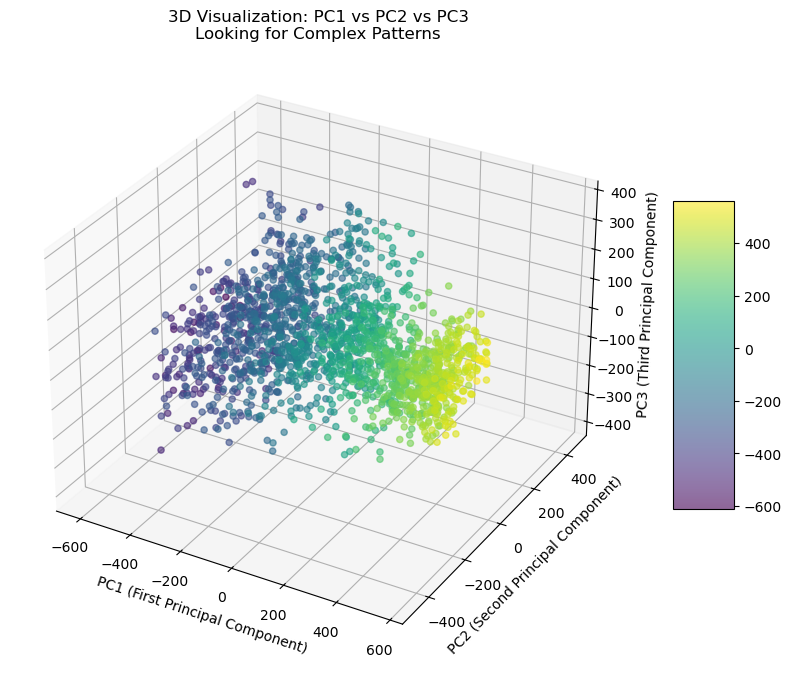

In [14]:
# 2. SCATTER PLOT 3D: PC1 vs PC2 vs PC3
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                    alpha=0.6, s=20, c=X_pca[:, 0], cmap='viridis')
ax.set_xlabel('PC1 (First Principal Component)')
ax.set_ylabel('PC2 (Second Principal Component)')
ax.set_zlabel('PC3 (Third Principal Component)')
ax.set_title('3D Visualization: PC1 vs PC2 vs PC3\nLooking for Complex Patterns')

# Add colorbar
plt.colorbar(scatter, shrink=0.5, aspect=5)
plt.show()



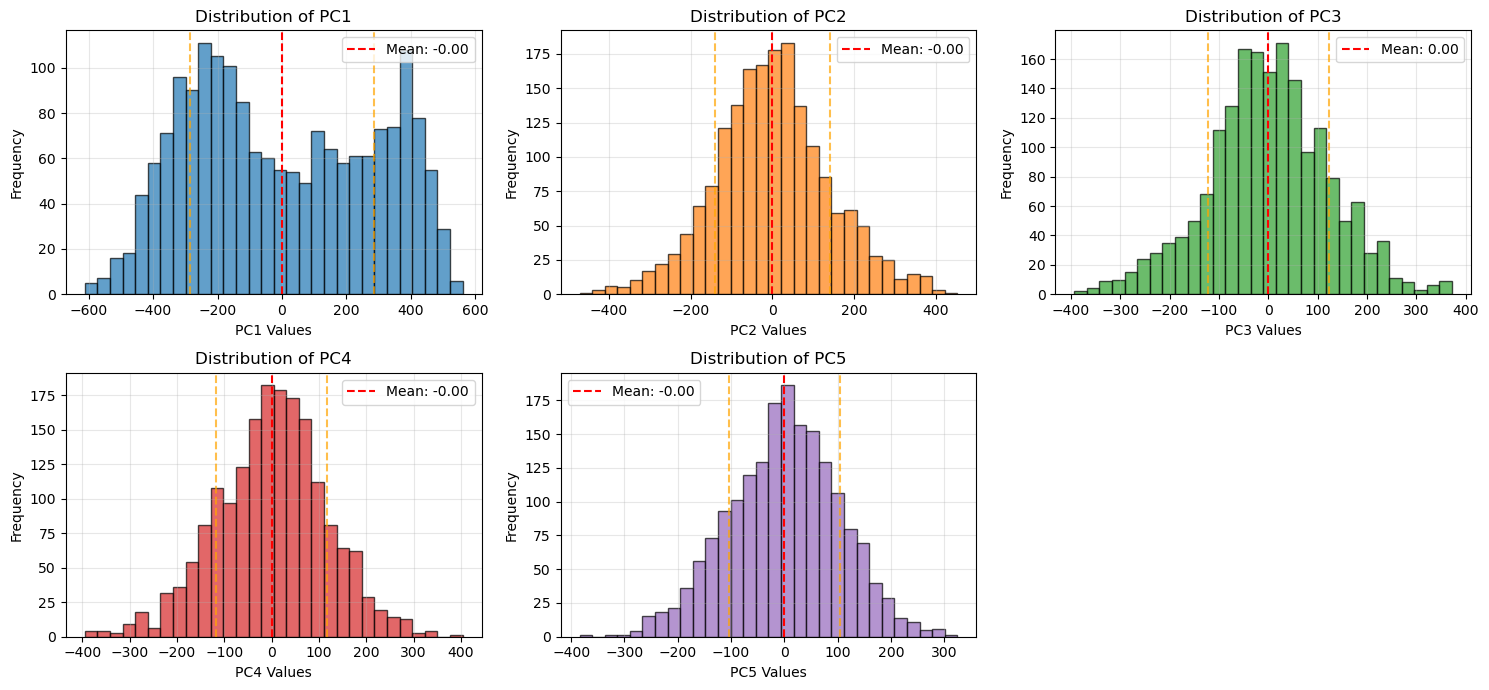


   • SUMMARY STATISTICS FOR FIRST 5 COMPONENTS:
   • PC1: Mean=-0.000, Std=285.862, Min=-611.818, Max=560.655
   • PC2: Mean=-0.000, Std=140.579, Min=-472.395, Max=452.976
   • PC3: Mean=0.000, Std=122.694, Min=-393.366, Max=372.242
   • PC4: Mean=-0.000, Std=116.627, Min=-394.477, Max=403.391
   • PC5: Mean=-0.000, Std=104.091, Min=-384.348, Max=324.298


In [15]:
# 3. HISTOGRAMS of first 5 components
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i in range(5):
    axes[i].hist(X_pca[:, i], bins=30, alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[i].set_xlabel(f'PC{i+1} Values')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of PC{i+1}')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = X_pca[:, i].mean()
    std_val = X_pca[:, i].std()
    axes[i].axvline(mean_val, color='red', linestyle='--', 
                   label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(mean_val + std_val, color='orange', linestyle='--', alpha=0.7)
    axes[i].axvline(mean_val - std_val, color='orange', linestyle='--', alpha=0.7)
    axes[i].legend()

axes[5].remove()

plt.tight_layout()
plt.show()

# 4. SUMMARY STATISTICS
print("\n   • SUMMARY STATISTICS FOR FIRST 5 COMPONENTS:")
for i in range(5):
    pc_data = X_pca[:, i]
    print(f"   • PC{i+1}: Mean={pc_data.mean():.3f}, Std={pc_data.std():.3f}, "
          f"Min={pc_data.min():.3f}, Max={pc_data.max():.3f}")


**PC2, PC3, PC4, PC5** → Normal distributions centered at 0, as expected in normalized PCA. These components show typical Gaussian-like behavior with:
- Mean ≈ 0 
- Symmetric, bell-shaped distributions
- Standard deviations around 1, indicating proper normalization

**PC1** → **Bimodal distribution**   
The bimodal pattern indicates that PC1 effectively separates the data into **two distinct groups**. This suggests:
- Two dominant meteorological regimes in European weather patterns
- PC1 captures the primary mode of atmospheric variability that distinguishes between these regimes
- Strong evidence for natural clustering structure in the data

VISUALIZZAZIONE DELLA PRIME COMPONENTI PRINCIPALI


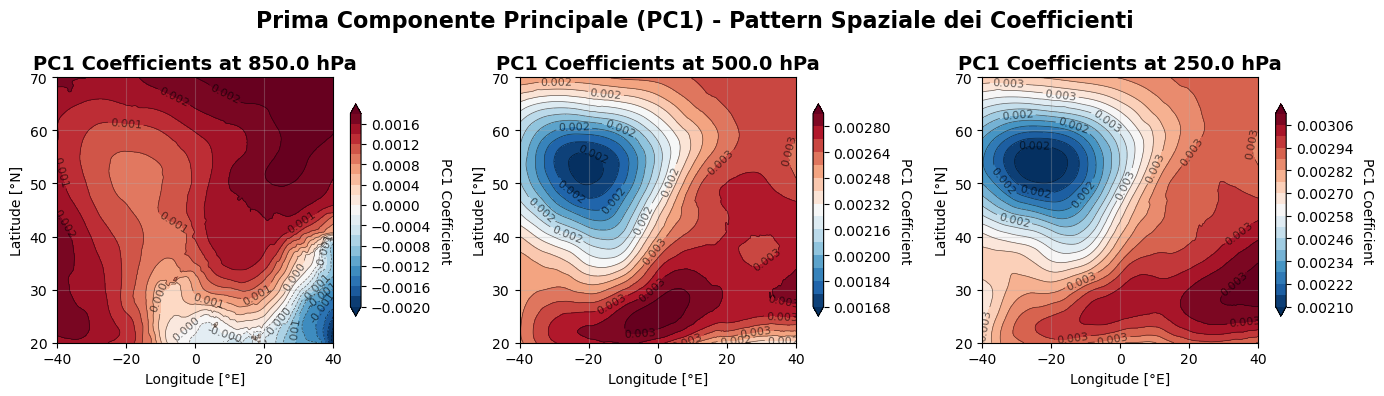

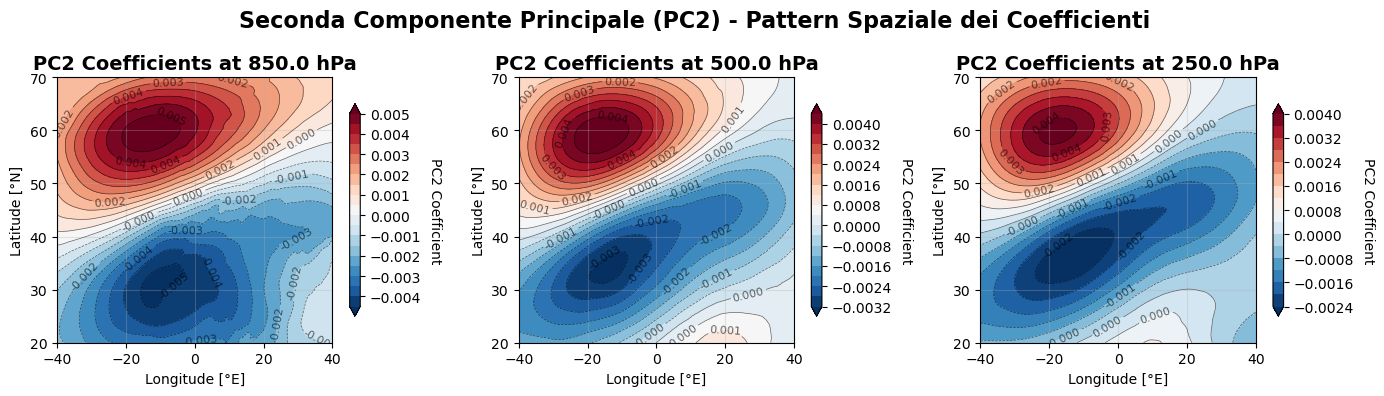

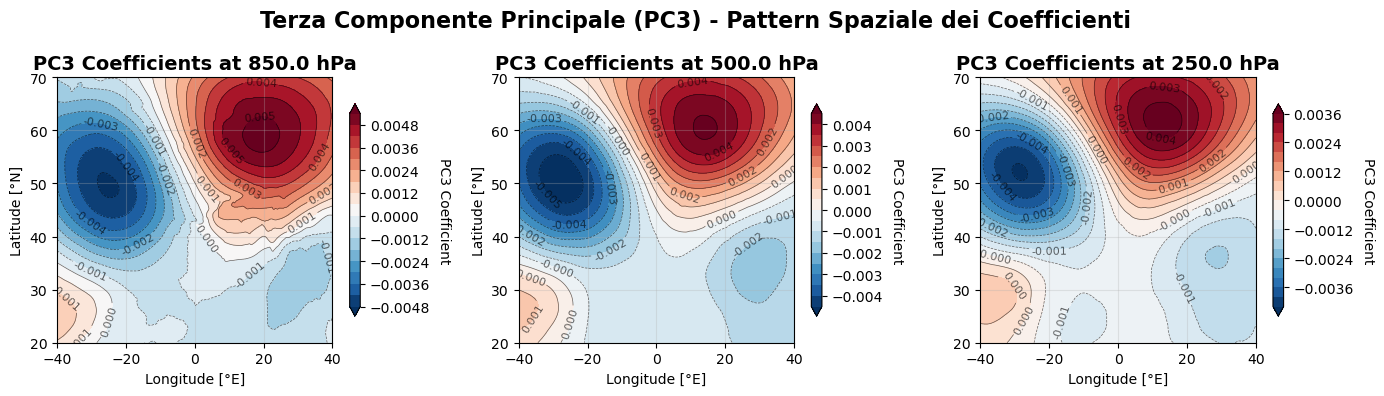


   • STATISTICHE COMPARATIVE PER LIVELLO DI PRESSIONE:
   • Pressure   PC1 Min      PC1 Max      PC2 Min      PC2 Max      PC3 Min      PC3 Max     
   • ------------------------------------------------------------------------------------
   • 850.0      -0.002128    0.001950     -0.004748    0.005349     -0.004889    0.005620    
   • 500.0      0.001645     0.002925     -0.003355    0.004780     -0.004873    0.004598    
   • 250.0      0.002040     0.003147     -0.002742    0.004162     -0.004445    0.003777    


In [16]:
print("VISUALIZZAZIONE DELLA PRIME COMPONENTI PRINCIPALI")

components_to_plot = [
    (ipca.components_[0], "PC1", "Prima Componente Principale (PC1)"),
    (ipca.components_[1], "PC2", "Seconda Componente Principale (PC2)"),
    (ipca.components_[2], "PC3", "Terza Componente Principale (PC3)")
]
n_lat = ds.dims['latitude'] if 'latitude' in ds.dims else len(ds.latitude)
n_lon = ds.dims['longitude'] if 'longitude' in ds.dims else len(ds.longitude)
n_pressure = ds.dims['isobaricInhPa'] if 'isobaricInhPa' in ds.dims else len(ds.isobaricInhPa)

lats = ds.latitude.values
lons = ds.longitude.values
pressure_levels = ds.isobaricInhPa.values.tolist()


for pc_coefficients, pc_name, pc_title in components_to_plot:
    
    # Forma originale dei coefficienti
    pc_reshaped = pc_coefficients.reshape(n_pressure, n_lat, n_lon)
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    for i, (pressure, ax) in enumerate(zip(pressure_levels, axes)):
        # Dati per questo livello di pressione
        pc_level = pc_reshaped[i, :, :]
        
        # Coordinate per la mappa
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        
        # Contour plot
        contour_lines = ax.contour(lon_grid, lat_grid, pc_level, 
                                  levels=20, linewidths=0.5, colors='black', alpha=0.6)
        
        # Contour filled
        contour_filled = ax.contourf(lon_grid, lat_grid, pc_level, 
                                    levels=20, cmap="RdBu_r", extend='both')
        
        # Etichette delle isolinee
        ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.3f')
        
        ax.set_title(f'{pc_name} Coefficients at {pressure} hPa', fontsize=14, fontweight='bold')
        ax.set_xlabel('Longitude [°E]')
        ax.set_ylabel('Latitude [°N]')
        ax.set_xlim([lons.min(), lons.max()])
        ax.set_ylim([lats.min(), lats.max()])
        ax.grid(True, alpha=0.3)
        
        cbar = plt.colorbar(contour_filled, ax=ax, shrink=0.8)
        cbar.set_label(f'{pc_name} Coefficient', rotation=270, labelpad=15)
    
    # Titolo generale
    fig.suptitle(f'{pc_title} - Pattern Spaziale dei Coefficienti', 
                 fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Statistiche comparative per tutte le componenti
print(f"\n   • STATISTICHE COMPARATIVE PER LIVELLO DI PRESSIONE:")
print(f"   • {'Pressure':<10} {'PC1 Min':<12} {'PC1 Max':<12} {'PC2 Min':<12} {'PC2 Max':<12} {'PC3 Min':<12} {'PC3 Max':<12}")
print(f"   • {'-'*84}")

# Ricostruisci tutte le componenti per le statistiche
pc1_reshaped = components_to_plot[0][0].reshape(n_pressure, n_lat, n_lon)
pc2_reshaped = components_to_plot[1][0].reshape(n_pressure, n_lat, n_lon)
pc3_reshaped = components_to_plot[2][0].reshape(n_pressure, n_lat, n_lon)

for i, pressure in enumerate(pressure_levels):
    pc1_level = pc1_reshaped[i, :, :]
    pc2_level = pc2_reshaped[i, :, :]
    pc3_level = pc3_reshaped[i, :, :]
    
    print(f"   • {pressure:<10} {pc1_level.min():<12.6f} {pc1_level.max():<12.6f} "
          f"{pc2_level.min():<12.6f} {pc2_level.max():<12.6f} "
          f"{pc3_level.min():<12.6f} {pc3_level.max():<12.6f}")

<span style="color: orange;">PRIMA DI FARE K-MEANS CERCO DI CAPIRE S EHA SENSO PESARE LE COMPONENTI PRINCIPALI
</span>  --> NO



Prima di applicare il K-means clustering, dobbiamo decidere se utilizzare direttamente le componenti PCA o se pesarle in base alla loro importanza (varianza spiegata).




**Dall'analisi emerge che:**

1. **PC1 domina fortemente** con 42.2% di varianza spiegata (rapporto 84.7:1 rispetto alle componenti minori)

2. **La pesatura cambia significativamente la struttura:**
   - Riduce il range di PC2 del 68% 
   - Aumenta il rapporto PC1/PC2 da 4.1:1 a 17.1:1
   - Enfatizza eccessivamente PC1 a discapito delle altre componenti

3. **Separabilità dei cluster:**
   - Standard PCA: mantiene una buona separazione bimodale visibile in PC1 vs PC2
   - Weighted PCA: comprime troppo PC2, perdendo informazione sulla separazione

**Utilizzare Standard PCA (non pesata)**

**Motivazioni:**
- ✅ La bimodalità di PC1 è già evidente e non serve enfatizzarla ulteriormente
- ✅ PC2 e PC3 contengono pattern meteorologici secondari importanti per distinguere sottogruppi
- ✅ Le componenti minori possono catturare pattern regionali o stagionali rilevanti
- ✅ Il K-means funziona meglio quando tutte le dimensioni hanno scale comparabili


_scrivo la motivazione per cui non è sensato pesare le pcs_

## 3 Clusterization

Now that we have analyzed the data, we have performed Principal Component Analysis (PCA) in order to reduce the dimensionality of the dataset and to highlight the most relevant features and components.
The next step is to implement an algorithm to cluster the data. The first method we will apply is the k-means algorithm.

### 3.1 K-means Implementation

The k-means algorithm allows us to divide the dataset into k groups (k is given, and we will perform an analysis later to determine the best value, as this is a key point). The association of each element in the dataset to a specific group is based on its attributes.

The goal of the algorithm is to minimize the total variance between different groups. Each group is identified through a centroid, note that they are not, in general, points from the dataset although they live in the same space.

Iteratively, the algorithm creates k partitions and assigns the incoming points to the groups. Then, it computes the centroids of each cluster and reassigns each point to the nearest centroid, using the Euclidean distance or another metric. The new centroids are then computed again, and the process continues until the method converges.

<span style="color: orange;">The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. </span>

_per me_  
**INIZIALIZZAZIONE**: k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is “greedy k-means++”. It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.  
‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.
If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.  
If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.  

**N_INIT** : Number of times the k-means algorithm is run with different centroid seeds. The final results is the best output of n_init consecutive runs in terms of inertia. Several runs are recommended for sparse high-dimensional problems

-  -  

_fit(X, y=None, sample_weight=None)_ --> computes k-means clustering. ----  _returns:_ Fitted estimator.

_fit_predict(X, y=None, sample_weight=None)_ --> Compute cluster centers and predict cluster index for each sample. --- _returns:_ Index of the cluster each sample belongs to.

_predict(X)_ --> Predict the closest cluster each sample in X belongs to. ---  _returns:_ Index of the cluster each sample belongs to.

_transform(X)_ --> Transform X to a cluster-distance space. In the new space, each dimension is the distance to the cluster centers. Note that even if X is sparse, the array returned by transform will typically be dense --- _returns:_ X transformed in the new space.

Dataset shape : (1827, 30)
Cluster counts(n° di campioni per cluster): [ 817 1010]
Labels shape: (1827,)
Labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Centroids shape: (2, 30)
Centroids: [[ 2.80466558e+02 -6.76216970e+00 -5.73622504e+00 -2.87443406e+00
  -4.89319971e+00 -4.85863169e+00 -1.37806525e+00 -3.61844957e+00
  -2.00065422e+00 -1.40991288e+00  8.33409643e-01 -8.09807899e-01
   7.40287727e-01 -1.98587253e-01  2.31532117e-01 -1.26938760e+00
  -2.36515950e-01  9.09015504e-01 -5.05178768e-01 -3.75112158e-01
  -2.45486699e-01  2.20838178e-01  7.84438163e-01 -5.78161548e-01
   5.46917761e-01 -3.68818367e-01  1.24671658e+00  1.77039925e-01
   3.51624506e-02  7.25129014e-01]
 [-2.26872454e+02  5.46999271e+00  4.64009491e+00  2.32516102e+00
   3.95816254e+00  3.93020009e+00  1.11473199e+00  2.92700327e+00
   1.61835099e+00 

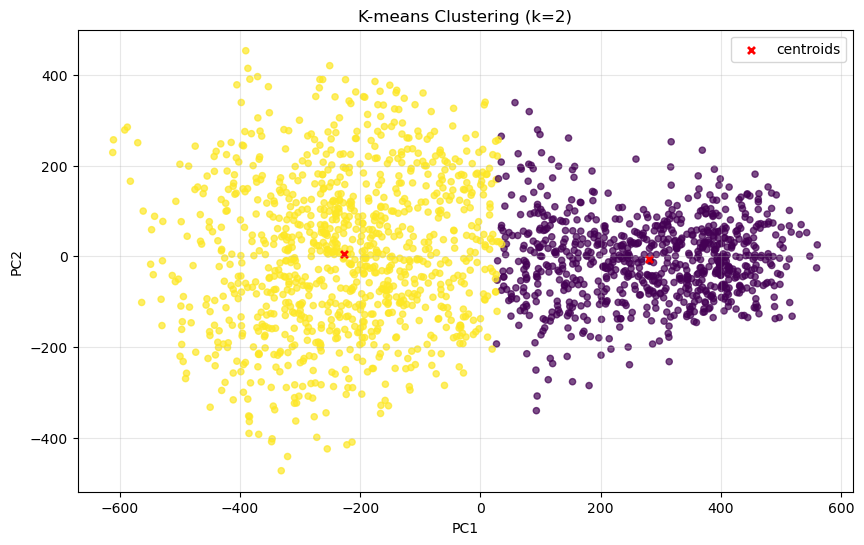

Cluster 0: 817 samples (44.7%)
Cluster 1: 1010 samples (55.3%)


In [ ]:
# STEP 2: Prepare the data
print(f"Dataset shape : {X_pca.shape}")

# STEP 3: Choose k (then we will try with differente values)
k = 2


# STEP 4: Create kmeans model
random_state = 123
n_init = 10
max_iter = 300
kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=n_init, max_iter=max_iter)


# Train the model
kmeans.fit(X_pca)

labels = kmeans.labels_
print(f"Cluster counts(n° di campioni per cluster): {np.bincount(labels)}")
print(f"Labels shape: {labels.shape}")
print(f"Labels: {labels[:100]}")  


# Compute the centroids
centroids= kmeans.cluster_centers_
print(f"Centroids shape: {centroids.shape}")
print(f"Centroids: {centroids[:5]}")

# Compute the inertia
inertia = kmeans.inertia_
print(f"Inertia (lower is better): {inertia:.2f}")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:,0], X_pca[:,1], c= labels, cmap='viridis', alpha = 0.7, s=20) 
plt.scatter(centroids[:,0], centroids[:,1], c= 'red', marker='x', s= 25, linewidths= 2, label= 'centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f"K-means Clustering (k={k})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


for i in range(k):
    cluster_size = np.sum(labels == i)
    print(f"Cluster {i}: {cluster_size} samples ({cluster_size/len(labels)*100:.1f}%)")

Il grafico mostra una separazione netta lungo PC1  
I due cluster sono chiaramente distinti  
I centroidi (X rosse) sono ben posizionati al centro di ogni cluster  
Osservazioni chiave:  
PC1 è il discriminante principale (come previsto dalla bimodalità)  
PC2 mostra variabilità interna ai cluster (normale)

**STAMPO I VETTORI DEI CENTROIDI CHE OTTENGO + FARE KMENAS CON K DIVERSI + CAPIRE SE DIVIDERE IL DATASET IN TRAIN E TEST**

#### 3.1.1 Evaluation of the best number of clusters (k)

_PER SELEZIONARE IL NUMERO DI CLUSTERS_ -->  https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py  

curva a gomito

#### 💡 Suggerimenti Extra per il K-means

**🔧 Se hai problemi, ecco alcuni tips:**

3. **Risultati strani?**
   - Prova con `random_state=42` per risultati riproducibili
   - Aumenta `n_init=20` se i risultati variano troppo

5. **Vuoi confrontare diversi k?**
   - Dopo aver fatto k=2, prova anche k=3, k=4, k=5
   - Salva l'inerzia di ognuno per confrontare

**🎯 Cosa aspettarsi:**
- Con k=2: dovresti vedere 2 cluster ben separati lungo PC1
- I centroidi dovrebbero essere punti rossi con X nel grafico
- Un cluster avrà più campioni dell'altro (distribuzione non uniforme)

### 3.2 Evaluation of the clustering

In this section we define a function to score different clustering pipelines using several metrics.  
Clustering algorithms are fundamentally unsupervised learning methods. However, since we happen to have class labels for this specific dataset, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters.If the ground truth labels are not known, evaluation can only be performed using the model results itself. In that case, the Silhouette Coefficient comes in handy.

In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar than members of different classes according to some similarity metric.

Studio   
•	https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation  
•	https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysishtml#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

e vedo quali usare
- silhouette
- dunn
- elbow
- -
- davies-bouldin
- rand index ? 
- Mutual Information based scores ? 
- Homogeneity, completeness and V-measure ?